In [4]:
# выключить среду
# from google.colab import runtime
# runtime.unassign()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Thesis_masters/TabDDPM'

/content/drive/MyDrive/Thesis_masters/TabDDPM


In [6]:
# !pip freeze

In [3]:
# !pip install -r requirements.txt

In [4]:
# !pip install synthcity

In [7]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

In [8]:
with open('./config.json', 'w', encoding='utf-8') as f:
    json.dump({
        'path': 'tabddpm.json',
        'model_name':'tabddpm'
    }, f, ensure_ascii=False, indent=4)

In [9]:
# download_dataset('adult')
# process_data('adult')

### Подготовка

In [10]:
model_name = 'tabddpm'
dataname = 'adult'

In [11]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [12]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")

if not CONFIG.get_arg('save_path'):
    CONFIG.add_arg('save_path',
                   f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")

Device: cuda


In [13]:
CONFIG.get_all_args()

{'dataname': 'adult',
 'method': 'tabddpm',
 'device': 'cuda',
 'save_path': 'synthetic/adult/tabddpm.csv',
 'mode': 'train',
 'train': 1,
 'sample_save_path': './generated_samples/adult.csv'}

### Train

In [14]:
CONFIG.add_arg('mode', 'train')

In [15]:
tabddpm = TabDDPM(CONFIG)

In [16]:
# tabddpm.train()

Text(0.5, 1.0, 'Model name: TABDDPM\nLoss by steps from step #1000')

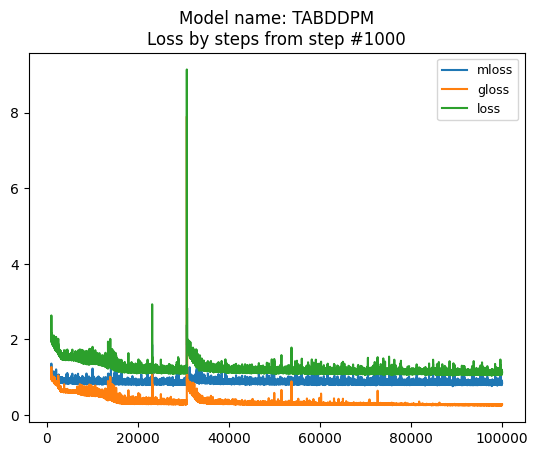

In [17]:
loss = pd.read_csv(f'./models/{model_name}/ckpt/{dataname}/loss.csv')

start_step = 1000
for l in loss.columns[1:]:
  plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")

In [18]:
CONFIG.add_arg('sample_save_path', './generated_samples/adult.csv')

In [19]:
# tabddpm.sample(sample_save_path=CONFIG.get_arg('sample_save_path'))

### Расчет метрик

In [20]:
from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

#### Метрики из starter_kit

In [21]:
calculate_base_metrics(make_binary=True, value=' >50K')

TABDDPM: ADULT Dataset
Original Logistic: 0.657
Synthetic Logistic: 0.655
Original Tree: 0.660
Synthetic Tree: 0.631 

TABDDPM Accuracy Loss: ADULT
Logistic: 0.364%
Tree: 4.394% 



#### Метрики из статьи TabSyn

In [22]:
calculate_similarity()

Output hidden; open in https://colab.research.google.com to view.

#### MLE

In [23]:
calculate_mle()

100%|██████████| 36/36 [00:28<00:00,  1.26it/s]


Saving scores to  eval/mle/adult/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.872 ± 0.005


#### Detection: classifier two sample tests (C2ST)

In [24]:
calculate_detection()

adult, tabddpm: 0.9695381409233916


#### DCR

In [25]:
calculate_DCR()

DCR Score, a value closer to 0.5 is better
adult-tabddpm, DCR Score = 0.6689290869445041


#### Alpha precision & Beta recall
_считаются только на CPU_

In [8]:
from eval.alpha_beta import calculate_alpha_beta
calculate_alpha_beta()

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.968539, beta recall: 0.479725
